In [1]:
! pip install picos

In [2]:
import pandas as pd
import numpy as np
import picos
import math
import scipy.stats 
import seaborn as sns
from picos import RealVariable, BinaryVariable
from picos import Constant
from picos import Problem
import cvxopt as cvx

In [3]:
alpha=0.05
c=1.1
p=500# size of regressor
n=100# size of sample

**$X: $**

In [22]:
X=pd.read_csv("x.csv",index_col=0)
X1=X.values
X=cvx.matrix(X1)
X1

array([[-1.36675798, -0.74284565, -0.57748888, ...,  1.41172344,
         1.43029807,  0.81551023],
       [-0.28201617, -0.7585696 , -0.5244693 , ...,  0.55637155,
        -0.18269256,  0.30013636],
       [ 0.34360411, -0.00320537,  0.06528472, ..., -0.61595947,
        -1.83206508,  0.47636161],
       ...,
       [-0.37381368, -0.06126036, -0.46648672, ..., -0.08628319,
         0.42041327,  1.11775372],
       [-1.65530135, -1.40439862,  0.85745825, ..., -0.93364097,
        -0.75007354, -0.66835894],
       [ 1.36345907,  0.91257985, -0.13424866, ...,  1.26498228,
         1.56960217,  1.07894828]])

$E_n(x x^{'})=\frac{\Sigma x_ix_i^{'}}{n}=\frac{X^{'}X}{n}$  


In [28]:
E_n=np.dot(X1.T,X1)/n

**$\beta_{0}$**  
set $\beta_{0}=(1,1,1,1,1,0,0,0...)$

In [30]:
belta_t=np.zeros(p)
belta_t[:5]=1

$y_i=X^{'}_i*\beta_0+\sigma \epsilon_i$

* $\epsilon_i \sim N(0,1)$

In [7]:
def get_y0_data(sigma):
    # input sigma
    #generate y with e N(0,1)
    epsilon=np.random.randn(n)
    y=np.dot(X1,belta_t)+sigma*epsilon
    return y

* $\epsilon_i \sim \frac{t_4}{\sqrt{2}}$

In [8]:
def get_y1_data(sigma):
    #input sigma
    #generate y with e t4/(2)^(1/2)
    epsilon=scipy.stats.t.rvs(4,size=n)/2**(0.5)
    y=np.dot(X1,belta_t)+sigma*epsilon
    return y

# square root lasso

##  $$\epsilon_i \sim \frac{t_4}{\sqrt{2}}$$

$$\lambda=c\bigwedge_{F}(1-\alpha|X)$$

compute the quantiles $$\bigwedge_{F}(1-\alpha|X)$$ by simulation

In [269]:
def cal_S(X):
    #input the sample matrix
    #output a simulation of \bigwedge
    epi=scipy.stats.t.rvs(4,size=n)/2**(0.5)
    epi=epi.reshape(n,-1)
    xepi=X*epi
    Exepi=sum(xepi)/n
    Eepi2=sum(epi**2)/n
    S=Exepi/(Eepi2**(1/2))
    gamma=n*max(abs(S))
    return gamma


 

In [270]:
def cal_lambda_t(N=10):
    #input simulation times N
    #output lambda_t
    lambda_t=0
    for i in range(N):
        t2=np.array([cal_S(X1) for i in range(10000)])
        t2=np.sort(t2)
        lambda_t=lambda_t+c*t2[9499]
    lambda_t=lambda_t/N
    return lambda_t

In [271]:
lambda_t=cal_lambda_t(10)

In [246]:
lambda_t

42.763877264117625

In [12]:
def calculate_p_n(dbelta):
    S=np.dot(np.dot(dbelta,E_n),dbelta)
    delta=S**(1/2)
    return delta

In [32]:
calculate_p_n(belta_t)

3.628782360898088

In [13]:
def oracle_estimate(y2):
    x0=X1[:,:5]
    A=np.dot(x0.T,x0)
    A_i=np.linalg.inv(A)
    beta=np.dot(np.dot(A_i,x0.T),y2)
    beta0=np.zeros(p)
    beta0[:5]=beta
    dbeta=beta0-belta_t
    delta=calculate_p_n(dbeta)
 # dbeta_o=sum((beta-belta_t[:5])**2)**(1/2)
    return delta

In [27]:
y2=get_y1_data(1)
oracle_estimate(y2)

0.3180648566961447

In [303]:
P2=Problem()
belta_plus=RealVariable("belta+",p)
belta_minus=RealVariable("belta-",p)
y_2=get_y1_data(1)
delta_o=oracle_estimate(y_2)
y_2=cvx.matrix(y_2)
t=RealVariable("t",1)
x=[Constant('x[{0}].T'.format(i), X[i,:]) for i in range(n)]
y=[Constant('y[{0}]'.format(i), y_2[i]) for i in range(n)]
v = RealVariable('V',n)
P2.add_list_of_constraints([(y[i]-x[i]*belta_plus+x[i]*belta_minus==v[i])  for i in range(n)])
P2.add_constraint(abs(v)<=t)
P2.add_constraint(belta_plus>=0)
P2.add_constraint(belta_minus>=0)
list1=np.zeros(p)
list2=np.zeros(p)
list1[::]=lambda_t/n
    #list2[::]=lambda_v/n
l1=Constant('Lambda/n',list1)
    #l2=Constant('Lambda/n',list2)
P2.set_objective('min',(t/10+(l1|belta_plus)+(l1|belta_minus)))
print(P2)

Second Order Cone Program
  minimize t/10 + ⟨Lambda/n, belta+⟩ + ⟨Lambda/n, belta-⟩
  over
    1×1 real variable t
    100×1 real variable V
    500×1 real variable belta+, belta-
  subject to
    y[i] - x[i].T·belta+ + x[i].T·belta- = V[i] ∀ i ∈ [0…99]
    ‖V‖ ≤ t
    belta+ ≥ 0
    belta- ≥ 0


In [249]:
def square_lasso_t(sigma):
    P2=Problem()
    belta_plus=RealVariable("belta+",p)
    belta_minus=RealVariable("belta-",p)
    y_2=get_y1_data(sigma)
    delta_o=oracle_estimate(y_2)
    y_2=cvx.matrix(y_2)
    t=RealVariable("t",1)
    x=[Constant('x[{0}].T'.format(i), X[i,:]) for i in range(n)]
    y=[Constant('y[{0}]'.format(i), y_2[i]) for i in range(n)]
    v = RealVariable('V',n)
    P2.add_list_of_constraints([(y[i]-x[i]*belta_plus+x[i]*belta_minus==v[i])  for i in range(n)])
    P2.add_constraint(abs(v)<=t)
    P2.add_constraint(belta_plus>=0)
    P2.add_constraint(belta_minus>=0)
    list1=np.zeros(p)
    list2=np.zeros(p)
    list1[::]=lambda_t/n
    #list2[::]=lambda_v/n
    l1=Constant('Lambda/n',list1)
    #l2=Constant('Lambda/n',list2)
    P2.set_objective('min',(t/10+(l1|belta_plus)+(l1|belta_minus)))
    P2.solve()
    belta=belta_plus-belta_minus
    #dbelta_n=abs(belta-belta_t).value
    belta=np.array([belta[i].value for i in range(p)])
    dbelta=belta-belta_t
    delta_t=calculate_p_n(dbelta)
    index=np.argwhere(abs(belta)>=0.0001)
    return belta,index,t.value,delta_t,delta_o

In [228]:
calculate_average_t(1)

(0.0, 0.0, 1.1817839465490343, 4.054618498021117)

In [250]:
def calculate_m_f(index):
    index1=index.reshape(-1)
    index1=index1.tolist()
    if len(index)==0:
        missing=5
        sum_false=0
    else:
        sum_true=0
        sum_false=0
        for i in index1:
            if(i  in range(5) ):
                sum_true=sum_true+1
            else: 
                sum_false=sum_false+1
        missing=5-sum_true
    return missing,sum_false

In [251]:
def calculate_average_t(sigma,N=8):
    miss=0
    false=0
    average_Q=0
    average_risk=0
    for i in range(N):
        belta,index,t.value,dbelta_n,belta_o=square_lasso_t(sigma=sigma)
        missing,sum_false=calculate_m_f(index)
        miss=miss+missing
        false=false+sum_false
        average_Q=average_Q+t.value/(10*sigma)
        average_risk=average_risk+dbelta_n/belta_o
    miss=miss/N
    false=false/N
    average_Q=average_Q/N
    average_risk=average_risk/N
    return miss,false,average_Q,average_risk

In [257]:
size=7
sigma1=np.array([.25,.5,1,1.5,2.0,2.5,3.0])
miss=np.zeros(size)
false=np.zeros(size)
average_Q=np.zeros(size)
average_r=np.zeros(size)
for i in range(size):
    miss1,false1,average_Qi,average_risk=calculate_average_t(sigma1[i])
    miss[i]=miss1
    false[i]=false1
    average_Q[i]=average_Qi
    average_r[i]=average_risk

In [293]:
miss

array([0.   , 0.   , 0.   , 0.   , 0.125, 0.125, 0.875])

In [294]:
false

array([0.   , 0.   , 0.   , 0.125, 0.   , 0.   , 0.   ])

Text(0.5, 1.0, '$\\epsilon_i\\sim t(4)/2^{1/2}$')

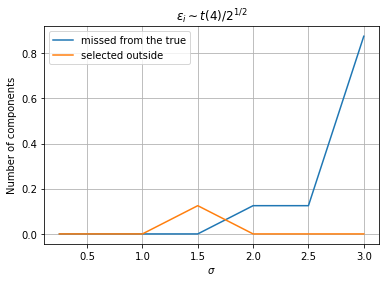

In [277]:
import matplotlib.pyplot as plt
plt.plot(sigma1,miss,sigma1,false)
plt.legend(["missed from the true","selected outside"])
plt.xlabel('$\sigma$')
plt.ylabel('Number of components')
plt.grid()
plt.title('$\epsilon_i\sim t(4)/2^{1/2}$')

In [272]:
average_Q

array([1.27455153, 1.16680912, 1.22885233, 1.1741965 , 1.12828494,
       1.1174895 , 1.16008542])

Text(0.5, 1.0, '$\\epsilon_i\\sim t(4)/2^{1/2}$')

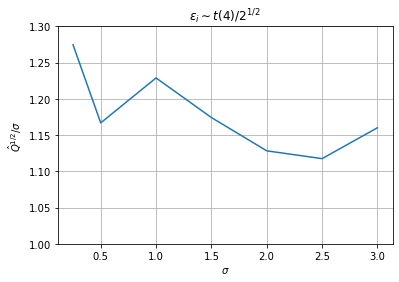

In [284]:
plt.plot(sigma1,average_Q)
plt.xlabel('$\sigma$')
plt.ylabel('$\hat{Q}^{1/2}/\sigma$')
plt.ylim([1,1.3])
plt.grid()
plt.title('$\epsilon_i\sim t(4)/2^{1/2}$')

In [258]:
average_r

array([3.97836634, 3.68876387, 3.76872729, 4.21904542, 3.58079638,
       4.26134759, 3.62340175])

Text(0.5, 1.0, '$\\epsilon_i\\sim t(4)/2^{1/2}$')

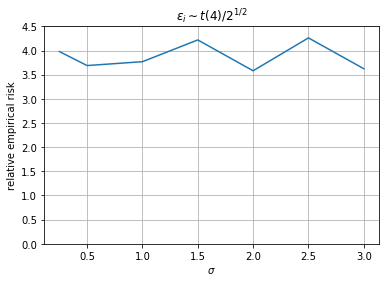

In [282]:
plt.plot(sigma1,average_r)
plt.xlabel('$\sigma$')
plt.ylabel('relative empirical risk')
plt.ylim([0,4.5])
plt.grid()
plt.title('$\epsilon_i\sim t(4)/2^{1/2}$')

## $\epsilon_i \sim N(0,1)$

$$
\lambda=cn^{1/2}\Phi^{-1}(1-\frac{\alpha}{2p})
$$

In [9]:
lambda_v=c*n**(1/2)*3.885

In [14]:
def square_lasso_n(sigma):
    P2=Problem()
    belta_plus=RealVariable("belta+",p)
    belta_minus=RealVariable("belta-",p)
    y_2=get_y0_data(sigma)
    delta_o=oracle_estimate(y_2)
    y_2=cvx.matrix(y_2)
    t=RealVariable("t",1)
    x=[Constant('x[{0}].T'.format(i), X[i,:]) for i in range(n)]
    y=[Constant('y[{0}]'.format(i), y_2[i]) for i in range(n)]
    v = RealVariable('V',n)
    P2.add_list_of_constraints([(y[i]-x[i]*belta_plus+x[i]*belta_minus==v[i])  for i in range(n)])
    P2.add_constraint(abs(v)<=t)
    P2.add_constraint(belta_plus>=0)
    P2.add_constraint(belta_minus>=0)
    list1=np.zeros(p)
    list2=np.zeros(p)
    list1[::]=lambda_v/n
    l1=Constant('Lambda/n',list1)
    P2.set_objective('min',(t/10+(l1|belta_plus)+(l1|belta_minus)))
    P2.solve()
    belta=belta_plus-belta_minus
    #dbelta_n=abs(belta-belta_t).value
    belta=np.array([belta[i].value for i in range(p)])
    dbelta=belta-belta_t
    delta_t=calculate_p_n(dbelta)
    index=np.argwhere(abs(belta)>=0.0001)
    return belta,index,t.value,delta_t,delta_o

In [286]:
def calculate_average_n(sigma,N=8):
    miss=0
    false=0
    average_Q=0
    average_risk=0
    for i in range(N):
        belta,index,t.value,dbelta_n,belta_o=square_lasso_n(sigma=sigma)
        missing,sum_false=calculate_m_f(index)
        miss=miss+missing
        false=false+sum_false
        average_Q=average_Q+t.value/(10*sigma)
        average_risk=average_risk+dbelta_n/belta_o
    miss=miss/N
    false=false/N
    average_Q=average_Q/N
    average_risk=average_risk/N
    return miss,false,average_Q,average_risk

In [287]:
size=7
sigma1=np.array([.25,.5,1,1.5,2.0,2.5,3.0])
miss_n=np.zeros(size)
false_n=np.zeros(size)
average_Qn=np.zeros(size)
average_rn=np.zeros(size)
for i in range(size):
    miss1,false1,average_Qi,average_risk=calculate_average_n(sigma1[i])
    miss_n[i]=miss1
    false_n[i]=false1
    average_Qn[i]=average_Qi
    average_rn[i]=average_risk

In [296]:
miss_n

array([0.   , 0.   , 0.   , 0.   , 0.25 , 0.5  , 1.125])

In [297]:
false_n

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125])

Text(0.5, 1.0, '$\\epsilon_i\\sim N(0,1)$')

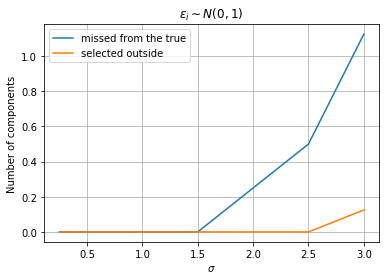

In [299]:
import matplotlib.pyplot as plt
plt.plot(sigma1,miss_n,sigma1,false_n)
plt.legend(["missed from the true","selected outside"])
plt.xlabel('$\sigma$')
plt.ylabel('Number of components')
plt.grid()
plt.title('$\epsilon_i\sim N(0,1)$')

In [290]:
average_Qn

array([1.27455153, 1.16680912, 1.22885233, 1.1741965 , 1.12828494,
       1.1174895 , 1.16008542])

Text(0.5, 1.0, '$\\epsilon_i\\sim N(0,1)$')

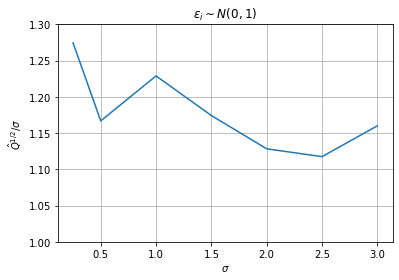

In [289]:
plt.plot(sigma1,average_Qn)
plt.xlabel('$\sigma$')
plt.ylabel('$\hat{Q}^{1/2}/\sigma$')
plt.ylim([1,1.3])
plt.grid()
plt.title('$\epsilon_i\sim N(0,1)$')

In [291]:
average_rn

array([3.97836634, 3.68876387, 3.76872729, 4.21904542, 3.58079638,
       4.26134759, 3.62340175])

Text(0.5, 1.0, '$\\epsilon_i\\sim N(0,1)$')

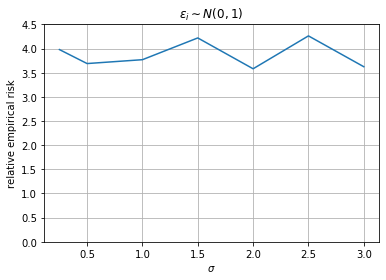

In [301]:
plt.plot(sigma1,average_rn)
plt.xlabel('$\sigma$')
plt.ylabel('relative empirical risk')
plt.ylim([0,4.5])
plt.grid()
plt.title('$\epsilon_i\sim N(0,1)$')